In [1]:
import os, sys
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import torch
import pandas as pd

# 0. Prepare Data
use `switch=True` to train across subjects and individually on each session

### specify the directories used for running the code:
* `data_dir`: where raw dataset is loaded; raw data is in csv format
* `processed_data_dir`: where processed dataset is loaded; processed data is in npy pickle format
    * processed data should be a ndarray of shape (participants_num x sessions_num(3) x days_per_session(10)*trail_per_day(4) x #examples_window*#mov(26*22=572) x processed_channel_num(252))
    * for instance: processed examples have shape **(5, 3, 40, 572, 252)** and labels have shape **(5, 3, 40, 572)**
* `path_<model_name>`: where model weights are saved
    * weights should be saved in folder `/Weights/<model_name>`. Each folder has subfolders containing weights for each participant.
    * weights for TSD model contain 3 set of training model. weights for DANN and SCADANN contain 2 set of trianing model (these two models are trianed based on TSD, so they do not have a best_state_0.pt model. 
* `save_<model_name>`: where model results are saved
    * each result for testing a model on a group of datset is saved in folder `results`. Each result has corresponding 
        * `<model_name>.txt` includes predictions, ground truths, array of accuracies for each participant and each session, and overall accuracy
        * `predictions_<model_name>.npy` includes array of accuracies, ground truths, predictions, and model outputs (probability array for each prediction)
        * remember to make blank files in these names before saving

* use `read_data_training` to process raw dataset
        

In [2]:
os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG_myo")
from PrepareAndLoadData.process_data import read_data_training

In [3]:
data_dir = "/home/laiy/gitrepos/msr_final/Wearable_Sensor_Long-term_sEMG_Dataset/data"
processed_data_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/Processed_datasets"
code_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo"
save_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/Results"

path_TSD ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights/TSD"
save_TSD = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

path_DANN ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights/DANN"
save_DANN = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

path_SCADANN ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights/SCADANN"
save_SCADANN = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

In [4]:
# read_data_training(path=data_dir, store_path = processed_data_dir, num_participant=5, switch=True)

In [5]:
# check stored pickle 
with open(processed_data_dir + "/training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)

examples_datasets_train = dataset_training['examples_training']
print('traning examples ', np.shape(examples_datasets_train))
labels_datasets_train = dataset_training['labels_training']
print('traning labels ', np.shape(labels_datasets_train))

traning examples  (3, 5, 40, 572, 252)
traning labels  (3, 5, 40, 572)


### Specify params used for training and testing

During training and testing, processed datasets are first put into pytorch dataloders, then feed to the model trainer; following are params for TSD model and dataloaders

* `num_kernels`: list of integers defining number of neurons used in each layer of linear block (linear block has `dropout`=0.5)
* `number_of_cycles_total`: number of trails performed for each session (assuming that all session have the same trail size)
    * 40 for myo
* `number_of_classes`: total number of gestures performed in dataset
    * 22 for myo
* `batch_size`: number of examples stored in each batch
* `feature_vector_input_length`: length of input array or each processed signal 
    * 252 for myo
* `learning_rate`= 0.002515
    

In [6]:
num_kernels=[200, 200, 200]                        # model layer size 
number_of_cycles_total=np.shape(examples_datasets_train[0][0])[0]               # #session
print("number_of_cycles_total ", number_of_cycles_total)
number_of_classes=22
batch_size=128          
feature_vector_input_length=252                     # size of one example 
learning_rate=0.002515

number_of_cycles_total  40


# 1. TSD_DNN
* `train_fine_tuning`: used to train data using TSD network only   
    * running this function will save three sets of TSD model weights (each is fine tuned based on the previous training)  
    
* `test_TSD_DNN_on_training_sessions`: test model result


### check if dataloaders are loaded correctly:
* each participant has shape (session_num x 40 x 572 x 252)
* each session has shape (40 x 572 x 252)
* put these data into on group ends up with shape (40*572=22880, 252)
    * shuffle on group of data and put into dataloaders
    * each participant should have 3 sets of dataloaders, each correspond to one session

In [7]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_standard import \
            test_TSD_DNN_on_training_sessions, train_fine_tuning

In [8]:
# train_fine_tuning(examples_datasets_train, labels_datasets_train,
#                   num_kernels=num_kernels, path_weight_to_save_to=path_TSD,
#                   number_of_classes=number_of_classes, number_of_cycles_total=number_of_cycles_total,
#                   batch_size=batch_size,
#                   feature_vector_input_length=feature_vector_input_length,
#                   learning_rate=learning_rate)

In [9]:
algo_name = "standard_TSD"
test_TSD_DNN_on_training_sessions(examples_datasets_train, labels_datasets_train,
                                  num_neurons=num_kernels, use_only_first_training=True,
                                  path_weights=path_TSD,
                                  feature_vector_input_length=feature_vector_input_length,
                                  save_path = save_TSD, algo_name=algo_name,
                                  number_of_cycles_total=number_of_cycles_total,
                                  number_of_classes=number_of_classes, cycle_for_test=3)

GET one participant_examples  (5, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  1
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  2
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  3
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one g

Participant:  1  Accuracy:  0.6213286713286713
2  SESSION   data =  5720
Participant:  1  Accuracy:  0.5131118881118881
3  SESSION   data =  5720
Participant:  1  Accuracy:  0.35262237762237764
4  SESSION   data =  5720
Participant:  1  Accuracy:  0.4590909090909091
ACCURACY PARTICIPANT  1 :  [0.8830419580419581, 0.6213286713286713, 0.5131118881118881, 0.35262237762237764, 0.4590909090909091]
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=252, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=252, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (

In [10]:
results_filename = save_TSD + '/predictions_' + algo_name + "_no_retraining.npy"
results = np.load(results_filename, allow_pickle=True)
TSD_acc = results[0]
TSD_acc_overall = np.mean(TSD_acc)
TSD_df = pd.DataFrame(TSD_acc.transpose(), 
                       index = [f'Participant_{i}' for i in range(TSD_acc.shape[1])],
                        columns = [f'Session_{j}' for j in range(TSD_acc.shape[0])])
TSD_df

,Session_0,Session_1,Session_2
Participant_0,0.887762,0.883042,0.875175
Participant_1,0.673252,0.621329,0.536538
Participant_2,0.446678,0.513112,0.369755
Participant_3,0.322902,0.352622,0.306993
Participant_4,0.487937,0.459091,0.368357


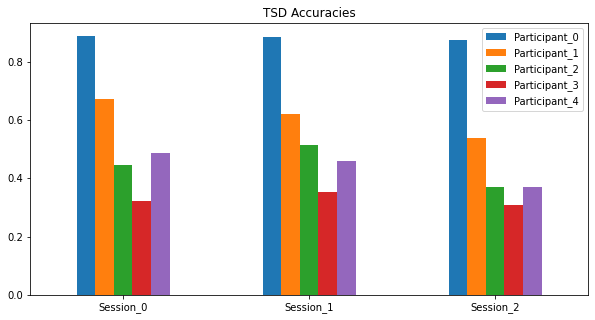

In [11]:
TSD_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("TSD Accuracies")
plt.show()

# 2. DANN
* `train_DANN`: train DANN model using the first set of training weights from TSD model
    * two set of training weights will be saved
* `test_DANN_on_training_sessions`: test DANN model

In [12]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_DA import train_DANN, test_DANN_on_training_sessions

In [13]:
# train_DANN(examples_datasets_train, labels_datasets_train, 
#           num_kernels=num_kernels,
#           path_weights_fine_tuning=path_TSD,
#           number_of_classes=number_of_classes,
#           number_of_cycles_total = number_of_cycles_total,
#           batch_size=batch_size,
#           feature_vector_input_length=feature_vector_input_length,
#           path_weights_to_save_to=path_DANN, learning_rate=learning_rate)

In [14]:
algo_name = "DANN"
test_DANN_on_training_sessions(examples_datasets_train, labels_datasets_train,
                              feature_vector_input_length=feature_vector_input_length,
                              num_neurons=num_kernels, path_weights_DA=path_DANN,
                              algo_name=algo_name, save_path = save_DANN, 
                              number_of_cycles_total=number_of_cycles_total,
                              path_weights_normal=path_TSD, number_of_classes=number_of_classes,
                              cycle_for_test=3)

GET one participant_examples  (5, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  1
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  2
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  3
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one g

Participant ID:  1  Session ID:  0  Accuracy:  0.8830419580419581
Participant ID:  1  Session ID:  1  Accuracy:  0.6987762237762237
Participant ID:  1  Session ID:  2  Accuracy:  0.49877622377622377
Participant ID:  1  Session ID:  3  Accuracy:  0.5026223776223776
Participant ID:  1  Session ID:  4  Accuracy:  0.51993006993007
ACCURACY PARTICIPANT:  [0.8830419580419581, 0.6987762237762237, 0.49877622377622377, 0.5026223776223776, 0.51993006993007]
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=252, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=252, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2

In [15]:
results_filename = save_DANN + '/predictions_' + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
DANN_acc = results[0]
DANN_acc_overall = np.mean(DANN_acc)
DANN_df = pd.DataFrame(DANN_acc.transpose(), 
                       index = [f'Participant_{i}' for i in range(DANN_acc.shape[1])],
                        columns = [f'Session_{j}' for j in range(DANN_acc.shape[0])])
DANN_df

,Session_0,Session_1,Session_2
Participant_0,0.887762,0.883042,0.875175
Participant_1,0.72972,0.698776,0.605944
Participant_2,0.515734,0.498776,0.436888
Participant_3,0.463811,0.502622,0.402622
Participant_4,0.524476,0.51993,0.404371


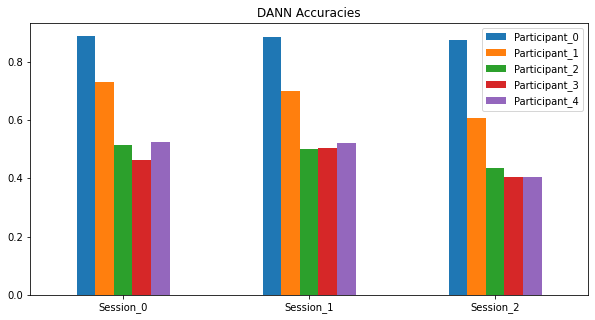

In [16]:
DANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("DANN Accuracies")
plt.show()

# 3. SCADANN
* `run_SCADANN_training_sessions`: train SCADANN model. The first session uses TSD model_0 wegits; others use DANN weights
    * specify `percentage_same_gesture_stable` based on the performance of most pseudo labels 
        * print accuracies out and check what percentage will optimize `ACCURACY MODEL` and `ACCURACY PSEUDO` without cutting out too much data 
    * two set of training weights will be saved
* `test_network_SLADANN`: test DANN model

In [17]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_SCADANN import run_SCADANN_training_sessions, test_network_SLADANN

In [18]:
# percentage_same_gesture_stable = 0.75 
# run_SCADANN_training_sessions(examples_datasets=examples_datasets_train, labels_datasets=labels_datasets_train,
#                               num_kernels=num_kernels, feature_vector_input_length=feature_vector_input_length,
#                               path_weights_to_save_to=path_SCADANN,
#                               path_weights_Adversarial_training=path_DANN,
#                               path_weights_Normal_training=path_TSD,
#                               number_of_cycles_total = number_of_cycles_total, 
#                               number_of_classes=number_of_classes,
#                               learning_rate=learning_rate)

In [19]:
algo_name = "SCADANN"
test_network_SLADANN(examples_datasets_train=examples_datasets_train, labels_datasets_train=labels_datasets_train,
                     num_neurons=num_kernels, feature_vector_input_length=feature_vector_input_length,
                     path_weights_SCADANN =path_SCADANN, path_weights_normal=path_TSD,
                     algo_name=algo_name, cycle_test=3, number_of_cycles_total=number_of_cycles_total,
                     number_of_classes=number_of_classes, save_path = save_SCADANN)

GET one participant_examples  (5, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  1
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  2
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  3
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one g

Participant:  1  Accuracy:  0.8830419580419581
Participant:  1  Accuracy:  0.7361888111888112
Participant:  1  Accuracy:  0.522027972027972
Participant:  1  Accuracy:  0.5517482517482517
Participant:  1  Accuracy:  0.5493006993006992
ACCURACY PARTICIPANT:  [0.8830419580419581, 0.7361888111888112, 0.522027972027972, 0.5517482517482517, 0.5493006993006992]
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=252, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=252, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0.5, inplace=False)
     

In [20]:
results_filename = save_SCADANN + '/predictions_' + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
SCADANN_acc = results[0]
SCADANN_acc_overall = np.mean(SCADANN_acc)
SCADANN_df = pd.DataFrame(SCADANN_acc.transpose(), 
                       index = [f'Participant_{i}' for i in range(SCADANN_acc.shape[1])],
                        columns = [f'Session_{j}' for j in range(SCADANN_acc.shape[0])])
SCADANN_df

,Session_0,Session_1,Session_2
Participant_0,0.887762,0.883042,0.875175
Participant_1,0.768182,0.736189,0.644755
Participant_2,0.55472,0.522028,0.454545
Participant_3,0.488636,0.551748,0.423252
Participant_4,0.584615,0.549301,0.433392


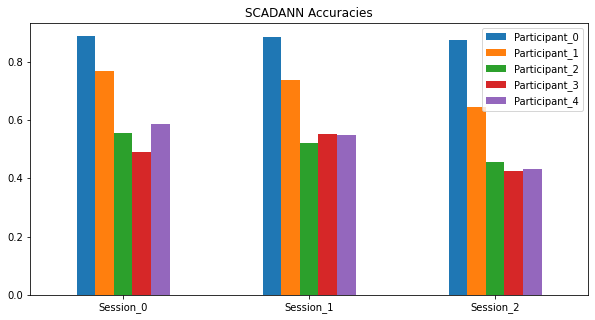

In [21]:
SCADANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("SCADANN Accuracies")
plt.show()

# Conclusion
Notice that when training across subejects, participant_idx and session_idx are switched in the saved model and result. 

Suppose there are a ndarray of NxM dataloaders, then N group of models will be trained, and each group will have M model. Each group is independent from each other, and each model within a group is dependent on its previous training weights. 

Each participant model is trained based on previous participant. Looking only at average accuracy of individual participant over all sessions below. SCADANN seems to be a feasible approach.

In [22]:
TSD_acc_overall_one = np.mean(TSD_acc, axis=0)
DANN_acc_overall_one = np.mean(DANN_acc, axis=0)
SCADANN_acc_overall_one = np.mean(SCADANN_acc, axis=0)
overall_acc_one_df = pd.DataFrame([TSD_acc_overall_one, DANN_acc_overall_one, SCADANN_acc_overall_one],
                             index = ["TSD", "DANN", "SCADANN"],
                             columns =[f'Participant_{i}' for i in range(DANN_acc.shape[1])])
overall_acc_one_df

,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
TSD,0.881993,0.610373,0.443182,0.327506,0.438462
DANN,0.881993,0.678147,0.483800,0.456352,0.482925
SCADANN,0.881993,0.716375,0.510431,0.487879,0.522436


Below is the accumulative accuracies of individual participant over all sessions. In general, SCADANN increase performance. Accuracy over all participants is dependant on how good participant_0 model is when testing on other participants.

In [23]:
accu_acc_TSD = []
accu_acc_DANN = []
accu_acc_SCADANN = []

for i in range(1,DANN_acc.shape[1]+1):
    accu_acc_TSD.append(np.mean(TSD_acc[:,:i]))
    accu_acc_DANN.append(np.mean(DANN_acc[:,:i]))
    accu_acc_SCADANN.append(np.mean(SCADANN_acc[:,:i]))

accu_df = pd.DataFrame([accu_acc_TSD, accu_acc_DANN, accu_acc_SCADANN],
                      index = ["TSD", "DANN", "SCADANN"],
                     columns =[f'Participant_{i}' for i in range(DANN_acc.shape[1])])
accu_df

,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
TSD,0.881993,0.746183,0.645183,0.565763,0.540303
DANN,0.881993,0.780070,0.681313,0.625073,0.596643
SCADANN,0.881993,0.799184,0.702933,0.649170,0.623823


In [24]:
print("TSD")
display(TSD_df)
print("DANN")
display(DANN_df)
print("SCADANN")
display(SCADANN_df)

TSD


,Session_0,Session_1,Session_2
Participant_0,0.887762,0.883042,0.875175
Participant_1,0.673252,0.621329,0.536538
Participant_2,0.446678,0.513112,0.369755
Participant_3,0.322902,0.352622,0.306993
Participant_4,0.487937,0.459091,0.368357


DANN


,Session_0,Session_1,Session_2
Participant_0,0.887762,0.883042,0.875175
Participant_1,0.72972,0.698776,0.605944
Participant_2,0.515734,0.498776,0.436888
Participant_3,0.463811,0.502622,0.402622
Participant_4,0.524476,0.51993,0.404371


SCADANN


,Session_0,Session_1,Session_2
Participant_0,0.887762,0.883042,0.875175
Participant_1,0.768182,0.736189,0.644755
Participant_2,0.55472,0.522028,0.454545
Participant_3,0.488636,0.551748,0.423252
Participant_4,0.584615,0.549301,0.433392


In [25]:
overall_acc_df = pd.DataFrame([TSD_acc_overall, DANN_acc_overall, SCADANN_acc_overall],
                             index = ["TSD", "DANN", "SCADANN"],
                             columns = ["Overall_Acc"])
overall_acc_df

,Overall_Acc
TSD,0.540303
DANN,0.596643
SCADANN,0.623823


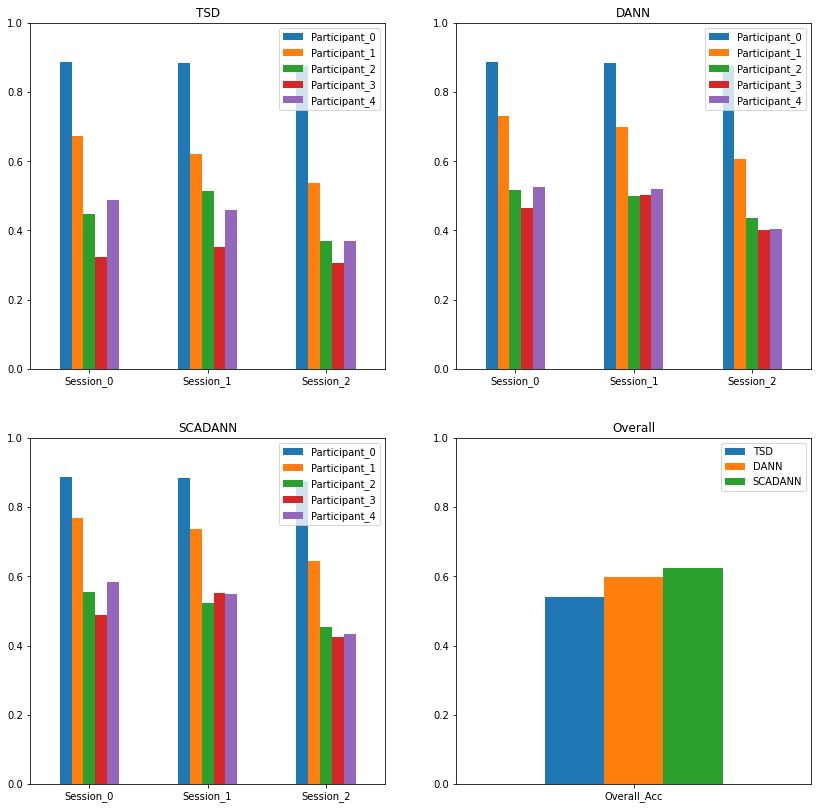

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
acc_list = [TSD_df, DANN_df, SCADANN_df, overall_acc_df]
title_list = ["TSD", "DANN", "SCADANN", "Overall"]
for idx, ax in enumerate(axes.reshape(-1)): 
    acc_list[idx].transpose().plot.bar(ax = ax, rot=0)
    ax.set_title(title_list[idx])
    ax.set_ylim([0, 1.0])